#AI Group Project ~ Deep Learning

##Prediction of Pumpkin Seed Type



Dataset ini berisi 2.500 data dan 13 features. Terdapat dua jenis biji labu, yaitu 'Urgup_Sivrisi' dan 'Cercevelik' yang umumnya ditanam di daerah Urgup dan Karacaoren di Turki. Project ini dilakukan untuk dapat mengklasifikasi jenis biji labu dengan data-data yang telah ada. Dataset diambil dari link https://www.kaggle.com/datasets/muratkokludataset/pumpkin-seeds-dataset

###Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import csv

###Dataset Visualization

In [ ]:
pumpkin_data = pd.read_excel('/content/drive/MyDrive/Datasets/Pumpkin_Seeds_Dataset.xlsx')
pumpkin_data.tail(10)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class
2490,51555,934.911,401.8321,164.7038,52013,256.2067,0.9121,0.9912,0.7187,0.7412,2.4397,0.6376,Ürgüp Sivrisi
2491,69836,1010.605,396.6286,224.7918,70419,298.1911,0.8239,0.9917,0.6693,0.8593,1.7644,0.7518,Ürgüp Sivrisi
2492,84236,1274.656,456.9323,237.1540,85248,327.4944,0.8548,0.9881,0.6104,0.6515,1.9267,0.7167,Ürgüp Sivrisi
2493,58987,977.410,404.0779,186.3710,59518,274.0522,0.8873,0.9911,0.7327,0.7759,2.1681,0.6782,Ürgüp Sivrisi
2494,79755,1146.431,470.3888,217.8296,80649,318.6647,0.8863,0.9889,0.7175,0.7626,2.1594,0.6774,Ürgüp Sivrisi
2495,79637,1224.710,533.1513,190.4367,80381,318.4289,0.9340,0.9907,0.4888,0.6672,2.7996,0.5973,Ürgüp Sivrisi
2496,69647,1084.318,462.9416,191.8210,70216,297.7874,0.9101,0.9919,0.6002,0.7444,2.4134,0.6433,Ürgüp Sivrisi
2497,87994,1210.314,507.2200,222.1872,88702,334.7199,0.8990,0.9920,0.7643,0.7549,2.2828,0.6599,Ürgüp Sivrisi
2498,80011,1182.947,501.9065,204.7531,80902,319.1758,0.9130,0.9890,0.7374,0.7185,2.4513,0.6359,Ürgüp Sivrisi
2499,84934,1159.933,462.8951,234.5597,85781,328.8485,0.8621,0.9901,0.7360,0.7933,1.9735,0.7104,Ürgüp Sivrisi


###About Dataset

In [ ]:
# Check value yang terdapat pada kolom 'Class'
pumpkin_data['Class'].value_counts()

Çerçevelik       1300
Ürgüp Sivrisi    1200
Name: Class, dtype: int64

In [ ]:
# Check null value
pumpkin_data.isnull().sum()

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ration        0
Compactness          0
Class                0
dtype: int64

In [ ]:
# Check zero value
pumpkin_data.isna().sum()

Area                 0
Perimeter            0
Major_Axis_Length    0
Minor_Axis_Length    0
Convex_Area          0
Equiv_Diameter       0
Eccentricity         0
Solidity             0
Extent               0
Roundness            0
Aspect_Ration        0
Compactness          0
Class                0
dtype: int64

###Random Forest

In [ ]:
# Membagi dataset ke k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

In [ ]:
# Menghitung presentase akurasi
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

In [ ]:
# Mengevaluasi algoritma dengan menggunakan cross validation split
from sklearn.metrics import accuracy_score, f1_score

def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		# Input and output for train and test
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_score(actual, predicted)
		f1 = f1_score(actual, predicted)
		scores.append({"accuracy": accuracy, "f1_score": f1})
	return scores

In [ ]:
# Membagi dataset berdasarkan atribute dan nilai atribute
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

In [ ]:
# Menghitung Gini index untuk membagi dataset
def gini_index(groups, classes):
	# Menghitung semua sample di titik pembagian
	n_instances = float(sum([len(group) for group in groups]))
	# Menjumlahkan Gini index untuk setiap grup
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# Menghindari terjadinya pembagian dengan nilai 0
		if size == 0:
			continue
		score = 0.0
		# Memberi skor kepada grup berdasarkan skor di tiap kelas
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# Menghitung skor tiap grup berdasarkan relatif sizenya
		gini += (1.0 - score) * (size / n_instances)
	return gini

In [ ]:
# Memilih titik pembagi terbaik untuk dataset
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [ ]:
# Membuat nilai node terminal
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

In [ ]:
# Membuat child splits untuk node atau membuat terminal
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# Cek jika tidak ada splits
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# Cek untuk kedalaman maksimal
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# Proses child sebelah kiri
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# Proses child sebelah kanan
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

In [ ]:
# Membentuk decision tree
def build_tree(train, max_depth, min_size, n_features):
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1)
	return root

In [ ]:
# Membuat prediksi dengan decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

In [ ]:
# Membuat subsample acak dari dataset dengan pengubahan
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

In [ ]:
# Membuat prediksi dengan menggunakan list dari bagged trees
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

In [ ]:
# Algoritma random forest
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)

In [ ]:
# ANOVA

import numpy as np
from scipy.stats import f as F_distribution

# Menghitung f-value
def f_classif_manual(X, y):
    classes = np.unique(y)
    k = 12
    class_means = []
    class_vars = []
    overall_mean = np.mean(X, axis=0)
    SST = np.sum((X - overall_mean) ** 2)

    for c in classes:
        X_c = X[y == c]
        class_means.append(np.mean(X_c, axis=0))
        class_vars.append(np.sum((X_c - class_means[-1]) ** 2))

    SSB = np.sum((class_means - overall_mean) ** 2)
    SSW = np.sum(class_vars)

    MSB = SSB / (len(classes) - 1)
    MSW = SSW / (X.shape[0] - len(classes))

    F = MSB / MSW
    p_value = 1 - F_distribution.cdf(F, len(classes) - 1, X.shape[0] - len(classes))

    return F, p_value

# Penerapan pada X dan y
def select_features(X, y):
    num_features = X.shape[1]
    F_values = np.zeros(num_features)
    p_values = np.zeros(num_features)

    for i in range(num_features):
        X_i = np.reshape(X[:, i], (-1, 1))
        F_values[i], p_values[i] = f_classif_manual(X_i, y)

    return F_values, p_values

In [ ]:
# Tes algoritma random forest
seed(2)

# Memuat dan mempersiapkan data (upload file dataset)
dataset = pd.read_excel('/content/drive/MyDrive/Datasets/Pumpkin_Seeds_Dataset.xlsx')
dataset_GAN = pd.read_csv('/content/drive/MyDrive/Datasets/5000_Pumpkin_Seeds_GAN_Dataset.csv')

# Menggabungkan data asli dan data sintetik
df = pd.concat([dataset, dataset_GAN])

# Mengubah kelas kolom ke integer
class_map = {'Çerçevelik': 0, 'Ürgüp Sivrisi': 1}
df['Class'] = df['Class'].replace(class_map)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

[index  0 ] Area :  66.61607640236087
[index  1 ] Perimeter :  142.900785689277
[index  2 ] Major_Axis_Length :  6.3912160179757835
[index  3 ] Minor_Axis_Length :  206.287765501183
[index  4 ] Convex_Area :  46.26042037664028
[index  5 ] Equiv_Diameter :  109.41127558677891
[index  6 ] Eccentricity :  164.58004760762628
[index  7 ] Solidity :  303.91580026499355
[index  8 ] Extent :  704.7398600699928
[index  9 ] Roundness :  695.2011597552288
[index  10 ] Aspect_Ration :  3.2376837390627897
[index  11 ] Compactness :  366.91389907458773


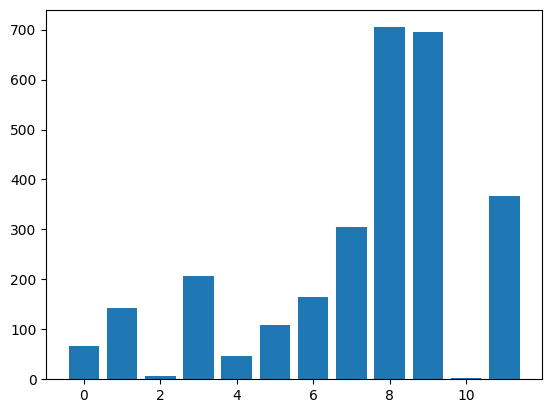

In [ ]:
# Menampilkan hasil ANOVA

F_values, p_values = select_features(X, y)
F_values = F_values*1000
X_feature = df.columns[:-1]

for i in range(len(F_values)):
  print("[index ", i, "]", X_feature[i], ": ", F_values[i])

plt.bar([i for i in range(len(F_values))], F_values)
plt.show()

In [ ]:
# Select dataset with the selected features
SELECTED_FEATURES = ['Solidity', 'Extent', 'Roundness', 'Aspect_Ration', 'Compactness']
SELECTED_FEATURES.append('Class')

USED_FEATURES = SELECTED_FEATURES

dataset_selected = df[USED_FEATURES]

# Menjalankan algoritma
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(np.sqrt(dataset_selected.shape[1]))
for n_trees in [1, 3, 5, 10]:
    result = evaluate_algorithm(dataset_selected.values.tolist(), random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
    acc = []
    f1 = []

    for res in result:
      acc.append(res['accuracy'])
      f1.append(res['f1_score'])

    print('Trees: %d' % n_trees)
    print('Scores: %s' % result)
    print('Mean Accuracy: %.3f%%' % (sum(acc)*100/float(len(acc))))
    print('Mean f1: %.3f%%' % (sum(f1)*100/float(len(f1))))

# DOCUMENTATION result on June 12th 4:39 PM execution time: 2h 11m 20s
# N_trees: 1
# accuracy: 0.86000 0.84600 0.87133 0.84200 0.85066 avg: 85.400%
# N_trees: 3
# accuracy: 0.87733 0.86133 0.87000 0.89066 0.86266 avg: 87.240%
# N_trees: 5
# accuracy: 0.83866 0.88200 0.88600 0.89333 0.89200 avg: 87.840%
# N_trees: 10
# accuracy: 0.88600 0.89133 0.88266 0.88200 0.88266 avg: 88.493%

Trees: 1
Scores: [{'accuracy': 0.86, 'f1_score': 0.8957298907646476}, {'accuracy': 0.846, 'f1_score': 0.8867091711623345}, {'accuracy': 0.8713333333333333, 'f1_score': 0.9015808261091279}, {'accuracy': 0.842, 'f1_score': 0.8820308611249377}, {'accuracy': 0.8506666666666667, 'f1_score': 0.8897637795275589}]
Mean Accuracy: 85.400%
Mean f1: 89.116%
Trees: 3
Scores: [{'accuracy': 0.8773333333333333, 'f1_score': 0.9085487077534792}, {'accuracy': 0.8613333333333333, 'f1_score': 0.8939857288481141}, {'accuracy': 0.87, 'f1_score': 0.9028400597907323}, {'accuracy': 0.8906666666666667, 'f1_score': 0.9192118226600986}, {'accuracy': 0.8626666666666667, 'f1_score': 0.8976143141153081}]
Mean Accuracy: 87.240%
Mean f1: 90.444%
Trees: 5
Scores: [{'accuracy': 0.8386666666666667, 'f1_score': 0.8791208791208791}, {'accuracy': 0.882, 'f1_score': 0.9133627019089575}, {'accuracy': 0.886, 'f1_score': 0.9138539042821159}, {'accuracy': 0.8933333333333333, 'f1_score': 0.9194360523665659}, {'accuracy': 0.892, 'f

In [ ]:
# Select dataset with the selected features
SELECTED_FEATURES = ['Solidity', 'Extent', 'Roundness', 'Aspect_Ration', 'Compactness']
SELECTED_FEATURES.append('Class')

USED_FEATURES = SELECTED_FEATURES

dataset_selected = df[USED_FEATURES]

# accuracy": accuracy, "f1_score": f1_score
# Menjalankan algoritma
n_folds = 5
max_depth = 10
min_size = 1
sample_size = 1.0
n_features = int(np.sqrt(dataset_selected.shape[1]))
n_trees = 3

results = []
for iter in range(5):
  result = evaluate_algorithm(dataset_selected.values.tolist(), random_forest, n_folds, max_depth, min_size, sample_size, n_features, n_trees)
  results.append(result)
  print(f"run[{iter}]: {result}")

print(results)

run[0]: [{'accuracy': 0.8386666666666667, 'f1_score': 0.8722280887011616}, {'accuracy': 0.85, 'f1_score': 0.8771163298743856}, {'accuracy': 0.8486666666666667, 'f1_score': 0.8778913394298009}, {'accuracy': 0.8566666666666667, 'f1_score': 0.8908075165058406}, {'accuracy': 0.852, 'f1_score': 0.883157894736842}]
run[1]: [{'accuracy': 0.8473333333333334, 'f1_score': 0.8779968034096964}, {'accuracy': 0.832, 'f1_score': 0.8677859391395593}, {'accuracy': 0.8526666666666667, 'f1_score': 0.8849557522123893}, {'accuracy': 0.8553333333333333, 'f1_score': 0.8856088560885608}, {'accuracy': 0.8306666666666667, 'f1_score': 0.8628509719222462}]
run[2]: [{'accuracy': 0.8353333333333334, 'f1_score': 0.8678437667201712}, {'accuracy': 0.8453333333333334, 'f1_score': 0.875268817204301}, {'accuracy': 0.854, 'f1_score': 0.8852802514405448}, {'accuracy': 0.8593333333333333, 'f1_score': 0.8884188260179798}, {'accuracy': 0.856, 'f1_score': 0.8872651356993738}]
run[3]: [{'accuracy': 0.8446666666666667, 'f1_score

In [ ]:
# DOCUMENTATION result on June 13th 8:56 PM execution time: 1h 9m 15s
# run [0] accuracy: 0.83866 0.85000 0.84866 0.85666 0.85200 avg: 0.84919
# run [1] accuracy: 0.84733 0.83200 0.85266 0.85533 0.83066 avg: 0.84359
# run [2] accuracy: 0.83533 0.84533 0.85400 0.85933 0.85600 avg: 0.84999
# run [3] accuracy: 0.84466 0.85333 0.83533 0.85000 0.84400 avg: 0.84546
# run [4] accuracy: 0.84266 0.84666 0.85533 0.83533 0.84466 avg: 0.84492

# Mean Accuracy sebelum feature selection dan data augmentation
# Iteration: 1 | Scores: [87.8, 86.4, 88.8, 86.4, 86.8] | Mean Accuracy: 0.87240
# Iteration: 2 | Scores: [87.0, 87.2, 86.2, 87.6, 87.8] | Mean Accuracy: 0.87160
# Iteration: 3 | Scores: [87.2, 87.2, 86.2, 84.0, 89.0] | Mean Accuracy: 0.86720
# Iteration: 4 | Scores: [85.0, 89.2, 87.2, 85.6, 85.2] | Mean Accuracy: 0.86440
# Iteration: 5 | Scores: [87.4, 90.0, 85.0, 84.8, 86.8] | Mean Accuracy: 0.86800

['run_0 mean: 0.8491960000000001', 'run_1 mean: 0.843596', 'run_2 mean: 0.849998', 'run_3 mean: 0.845464', 'run_4 mean: 0.844928']


###Statistical Analysis using t-test

In [38]:
# HYPOTHESIS TESTING
# H0: accuracy setelah GAN dan feature selection >= accuracy sebelum GAN dan feature selection
# H1: accuracy setelah GAN dan feature selection < accuracy sebelum GAN dan feature selection
# Hypothesis testing menggunakan metode statistik dengan t-test.
# significant level yang digunakan adalah .05

import scipy.stats as stats

meanresults = {
    'Before':[0.87240, 0.87160, 0.86720, 0.86440, 0.86800],
    'After': [0.84919, 0.84359, 0.84999, 0.84546, 0.84492],
}
t_statistics, p_value = stats.ttest_ind(results['Before'], results['After'])

if p_value < 0.05:
    print("Reject H0: result after GAN and feature selection has significantly lesser accuracy than before after GAN and feature selection.")
else:
    print("Fail to reject H0: result after GAN and feature selection has greater or equal accuracy compared to result before GAN and feature selection.")

print("p value:", p_value)

Reject H0: result after GAN and feature selection has significantly lesser accuracy than before after GAN and feature selection.
p value: 3.1043938516583285e-06


###Statistical analysis to compare between classifiers when data augmentation and feature selection have been carried out

In [44]:
from scipy.stats import f_oneway

# Membandingkan metode Decision Tree, Random Forest, dan XGBoost setelah dilakukan feature selection dan data augmentation
# Performa masing-masing metode direpresentasikan sebagai list atau array nilai akurasi
# Setiap metode menggunakan fold = 5 dan dilakukan iterasi sebanyak 5 kali
performa_dt = [0.823, 0.820, 0.818, 0.822, 0.825]
performa_rf = [0.850, 0.844, 0.850, 0.845, 0.845]
performa_xgb = [0.753, 0.752, 0.749, 0.752, 0.753]

# Melakukan analisis variansi (ANOVA) untuk membandingkan ketiga metode
statistik, p_value = f_oneway(performa_dt, performa_rf, performa_xgb)

# Hasil ANOVA
print("Statistik: {:.4f}".format(statistik))
print("p-value: {:.4f}".format(p_value))

# Menentukan metode yang lebih akurat berdasarkan p-value
alpha = 0.05  # Tingkat signifikansi yang ditentukan
if p_value < alpha:
    print("Terdapat perbedaan signifikan dalam performa metode-metode tersebut.")
    if performa_dt > performa_rf and performa_dt > performa_xgb:
        print("Metode Decision Tree lebih akurat.")
    elif performa_xgb > performa_dt and performa_rf > performa_xgb:
        print("Metode Random Forest lebih akurat.")
    else:
        print("Metode XGBoost lebih akurat.")
else:
    print("Tidak ada perbedaan signifikan dalam performa metode-metode tersebut.")

Statistik: 1942.7914
p-value: 0.0000
Terdapat perbedaan signifikan dalam performa metode-metode tersebut.
Metode XGBoost lebih akurat.
